In [29]:
import os
import re
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

load_dotenv()
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PGPASSWORD")
HOST = os.getenv("HOST")
PORT = os.getenv("PORT")
DATABASE = os.getenv("DATABASE")
URL = f"postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

ENGINE = create_engine(URL)

# Fetching constraints of database

In [30]:
query = """
SELECT 
    conname AS constraint_name,
    contype AS constraint_type,
    conrelid::regclass AS table_name,
    CASE 
        WHEN contype IN ('f', 'c') THEN confrelid::regclass::text
        ELSE NULL
    END AS referenced_table,
    conkey AS constraint_columns,
    confkey AS referenced_columns
FROM 
    pg_constraint
WHERE 
    conrelid::regclass::text NOT LIKE 'pg_%'
ORDER BY 
    conrelid::regclass::text, conname
"""

with ENGINE.connect() as conn:
    constraints = pd.DataFrame(conn.execute(text(query)))

constraints

,constraint_name,constraint_type,table_name,referenced_table,constraint_columns,referenced_columns
0,cardinal_number_domain_check,c,-,-,None,None
1,year_check,c,-,-,None,None
2,yes_or_no_check,c,-,-,None,None
3,actor_pkey,p,actor,None,[1],None
4,address_pkey,p,address,None,[1],None
5,fk_address_city,f,address,city,[5],[1]
6,category_pkey,p,category,None,[1],None
7,city_pkey,p,city,None,[1],None
8,fk_city,f,city,country,[3],[1]
9,country_pkey,p,country,None,[1],None


# Fetching column list from each table

In [31]:
query = """
SELECT
    c.table_schema,
    c.table_name,
    string_agg(c.column_name || ' (' || c.data_type || ')', ', ' ORDER BY c.ordinal_position) AS column_list
FROM
    information_schema.columns AS c
JOIN
    information_schema.tables AS t
    ON c.table_name = t.table_name
    AND c.table_schema = t.table_schema
WHERE
    t.table_type = 'BASE TABLE'
    AND t.table_schema NOT IN ('information_schema', 'pg_catalog')
GROUP BY
    c.table_schema,
    c.table_name
ORDER BY
    c.table_schema,
    c.table_name;
"""

with ENGINE.connect() as conn:
    columns = pd.DataFrame(conn.execute(text(query)))

columns[['table_name', 'column_list']].to_csv("../metadata/tables.txt", index=False, sep="\t", header=False)
columns

,table_schema,table_name,column_list
0,public,actor,"actor_id (integer), first_name (character vary..."
1,public,address,"address_id (integer), address (character varyi..."
2,public,category,"category_id (integer), name (character varying..."
3,public,city,"city_id (integer), city (character varying), c..."
4,public,country,"country_id (integer), country (character varyi..."
5,public,customer,"customer_id (integer), store_id (smallint), fi..."
6,public,film,"film_id (integer), title (character varying), ..."
7,public,film_actor,"actor_id (smallint), film_id (smallint), last_..."
8,public,film_category,"film_id (smallint), category_id (smallint), la..."
9,public,inventory,"inventory_id (integer), film_id (smallint), st..."


# Saving constraint of database

In [32]:
with open("../metadata/constraints.txt", "a") as f:
    for col in columns['table_name']:
        consts = constraints[constraints['table_name'] == col]
        for c in consts.iterrows():
            if c[1]['constraint_type'] == 'p':
                table_name = c[1]['table_name']
                column_list = columns[columns['table_name'] == table_name]['column_list'].values[0].split(', ')
                if len(c[1]['constraint_columns']) == 1:
                    constrained_index = int(c[1]['constraint_columns'][0]-1)
                else:
                    continue
                column_name = column_list[constrained_index]
                f.write(f"Column {column_name} is a primary key of the table {table_name}\n")
            elif c[1]['constraint_type'] == 'f':

                table_name = c[1]['table_name']
                column_list = columns[columns['table_name'] == table_name]['column_list'].values[0].split(', ')
                if len(c[1]['constraint_columns']) == 1:
                    constrained_index = int(c[1]['constraint_columns'][0]-1)
                else:
                    continue
                column_name = column_list[constrained_index]
                referenced_table = c[1]['referenced_table']
                referenced_columns = c[1]['referenced_columns']
                referenced_column_list = columns[columns['table_name'] == referenced_table]['column_list'].values[0].split(', ')
                referenced_column_name = referenced_column_list[referenced_columns[0]-1]
                f.write(f"Column {column_name} is a foreign key of the table {table_name} and references column {referenced_column_name} of the table {referenced_table}\n")


# Executing PowerShell script

In [33]:
import subprocess

script_path = '../scripts/postgres.ps1'

result = subprocess.run(['powershell.exe', '-ExecutionPolicy', 'Unrestricted', '-File', script_path], capture_output=True, text=True)

print(result.stderr)

# Clearing `metadata.sql`

In [34]:
with open("../metadata/metadata.sql", "r") as f:
    metadata = f.read()
    print(metadata.strip())

--
-- PostgreSQL database dump
--

-- Dumped from database version 16.4
-- Dumped by pg_dump version 16.4

SET statement_timeout = 0;
SET lock_timeout = 0;
SET idle_in_transaction_session_timeout = 0;
SET client_encoding = 'UTF8';
SET standard_conforming_strings = on;
SELECT pg_catalog.set_config('search_path', '', false);
SET check_function_bodies = false;
SET xmloption = content;
SET client_min_messages = warning;
SET row_security = off;

--
-- Name: mpaa_rating; Type: TYPE; Schema: public; Owner: postgres
--

CREATE TYPE public.mpaa_rating AS ENUM (
    'G',
    'PG',
    'PG-13',
    'R',
    'NC-17'
);


ALTER TYPE public.mpaa_rating OWNER TO postgres;

--
-- Name: year; Type: DOMAIN; Schema: public; Owner: postgres
--

CREATE DOMAIN public.year AS integer
	CONSTRAINT year_check CHECK (((VALUE >= 1901) AND (VALUE <= 2155)));


ALTER DOMAIN public.year OWNER TO postgres;

--
-- Name: _group_concat(text, text); Type: FUNCTION; Schema: public; Owner: postgres
--

CREATE FUNCTION publ

In [35]:
import re

def extract_create_table_statements(file_path, output_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Wyrażenie regularne do znalezienia poleceń CREATE TABLE
    pattern = re.compile(r'CREATE TABLE[\s\S]*?;', re.MULTILINE)
    matches = pattern.findall(content)

    with open(output_path, 'w') as file:
        for match in matches:
            file.write(match + '\n')

# Wykonaj funkcję
extract_create_table_statements('../metadata/metadata.sql', '../metadata/metadata.sql')


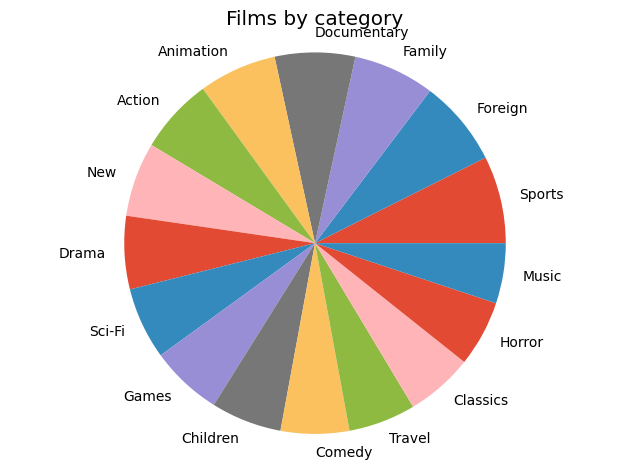

In [8]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

load_dotenv()

USERNAME = os.getenv('PGUSERNAME')
PASSWORD = os.getenv('PGPASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')
DATABASE = os.getenv('DATABASE')
URL = f'postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'

engine = create_engine(URL)

query = 'SELECT category.name, COUNT(film_category.film_id) AS film_count FROM film_category JOIN category ON film_category.category_id = category.category_id GROUP BY category.name ORDER BY film_count DESC NULLS LAST'

df = pd.read_sql(query, engine)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

category = df['name']
film_count = df['film_count']
colors = sns.color_palette()
plt.pie(x= film_count, labels=category, colors = colors)
plt.title("Films by category")
plt.axis('equal')
plt.tight_layout()
plt.savefig('plot.png', format='png')
plt.show()

In [7]:
data[1]

['Foreign', 73]